# South Sudan Data Precalculations

This notebook is used to precalculate data at different regions of South Sudan. 

## Data Hierarchy

The data is organized in the following hierarchy:

- [This](https://docs.google.com/spreadsheets/d/1RdJCjygAiWu2zBMGRF0ayigzrA2WhaObWMNdlkllgSQ/edit?usp=sharing) is the link to the data hierarchy spreadsheet.

## Data Access
The data is stored in the following Google Cloud Storage bucket:
- https://console.cloud.google.com/storage/browser/wbhydross_deliverables


## Setup

### Library import


In [1]:
# imports
import sys

import cartopy.crs as ccrs
import gcsfs
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import regionmask
import xarray as xr
from dask.distributed import Client

# Include local library paths if you have ../src/utils.py
sys.path.append("../src/")

**Start Dask Client for Dashboard**

In [2]:
client = Client()
client  # noqa: B018

NameError: name 'Client' is not defined

### Utils

In [3]:
def load_and_prepare_data(url: str, level: int) -> gpd.GeoDataFrame:
    """
    Load and prepare data from a given URL and level
    Parameters
    ----------
    url : str
        URL of the data
    level : int
    """
    df = gpd.read_file(url)
    df["level"] = level
    # Initialize columns list with common columns
    columns = ["level", "ADM0_EN", "ADM0_PCODE", "geometry"]
    # Dynamically add columns based on level
    for lvl in range(1, level + 1):
        columns.extend([f"ADM{lvl}_EN", f"ADM{lvl}_PCODE"])
    df = df[columns]
    df.columns = [column.lower() for column in df.columns]
    return df

# Data Acquisition
## Vector Data
### Administrative Boundaries

In [4]:
base_url = "https://storage.googleapis.com/wbhydross_deliverables/D3-Database/\
00-%20Ancillary%20Layers/OCHA-SubnationalAdministrativeBoundaries/\
WBHYDROSSD_OCHA_SubnationalAdministrativeBoundaries-adm{}_4326_SouthSudan_20230829_20240228.shp"
dataframes = [load_and_prepare_data(base_url.format(level), level) for level in range(4)]

adm = pd.concat(dataframes, axis=0)
# Reorder columns
columns_except_geometry = [col for col in adm.columns if col != "geometry"]
columns_new_order = columns_except_geometry + ["geometry"]
adm = adm[columns_new_order]

adm.head()

,level,adm0_en,adm0_pcode,adm1_en,adm1_pcode,adm2_en,adm2_pcode,adm3_en,adm3_pcode,geometry
0,0,South Sudan,SS,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((33.90147 10.16155, 33.90147 10.16155..."
0,1,South Sudan,SS,Central Equatoria,SS01,NaN,NaN,NaN,NaN,"POLYGON ((32.13885 4.70399, 32.12436 4.59871, ..."
1,1,South Sudan,SS,Eastern Equatoria,SS02,NaN,NaN,NaN,NaN,"POLYGON ((35.09476 5.7436, 35.1084 5.71964, 35..."
2,1,South Sudan,SS,Jonglei,SS03,NaN,NaN,NaN,NaN,"POLYGON ((30.55928 9.50145, 30.56094 9.50109, ..."
3,1,South Sudan,SS,Lakes,SS04,NaN,NaN,NaN,NaN,"POLYGON ((30.47487 7.07277, 30.53654 7.06721, ..."


### Hydrological Basins

In [13]:
basins = gpd.read_file(
    "https://storage.googleapis.com/wbhydross_deliverables/D3-Database/"
    "00-%20Ancillary%20Layers/HydroSHEDS/HydroBasins/"
    "WBHYDROSSD_HydroBASINS-polys_4326_SouthSudan_2023_20240506.shp"
)
basins.head()

,OBJECTID,ADM0_EN,ADM0_PCODE,BasinName,geometry
0,1,South Sudan,SS,Bahr-el-Ghazal,"POLYGON ((30.17083 9.29167, 30.17541 9.29284, ..."
1,2,South Sudan,SS,Bahr-el-Jebel,"MULTIPOLYGON (((32.24167 6.16250, 32.24917 6.1..."
2,3,South Sudan,SS,White Nile,"POLYGON ((34.14738 8.71171, 34.13138 8.69640, ..."
3,4,South Sudan,SS,Baro Akobbo Sobat,"POLYGON ((32.23750 6.16667, 32.23835 6.16335, ..."


## Raster Data
### Precipitation
[**Reading from the remote Zarr storage**](https://tutorial.xarray.dev/intermediate/cmip6-cloud.html#reading-from-the-remote-zarr-storage)

In [5]:
fs = gcsfs.GCSFileSystem(token="anon")
store = fs.get_mapper(
    "gs://wbhydross_deliverables/D3-Database/02- Meteorological datasets/Rainfall-CHIRPS/"
    "WBHYDROSSD_CHIRPS_5km_Precipitation_SouthSudan_1981_2022_20240425.zarr"
)
ds = xr.open_zarr(store=store, consolidated=True)
ds

<xarray.Dataset> Size: 3GB
Dimensions:               (time: 15340, y: 191, x: 251)
Coordinates:
  * time                  (time) datetime64[ns] 123kB 1981-01-01 ... 2022-12-31
  * x                     (x) float64 2kB 23.83 23.88 23.93 ... 36.28 36.33
  * y                     (y) float64 2kB 12.67 12.62 12.57 ... 3.225 3.175
Data variables:
    precipitation_amount  (time, y, x) float32 3GB ...
    spatial_ref           (time) int32 61kB ...

**Choose the variable of interest**: Precipitation amount

In [18]:
da = ds.precipitation_amount
da.attrs["units"] = "mm"
da

<xarray.DataArray 'precipitation_amount' (time: 15340, y: 191, x: 251)> Size: 3GB
dask.array<open_dataset-precipitation_amount, shape=(15340, 191, 251), dtype=float32, chunksize=(959, 24, 32), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 123kB 1981-01-01 1981-01-02 ... 2022-12-31
  * x        (x) float64 2kB 23.83 23.88 23.93 23.98 ... 36.18 36.23 36.28 36.33
  * y        (y) float64 2kB 12.67 12.62 12.57 12.52 ... 3.325 3.275 3.225 3.175
Attributes:
    accumulation_interval:  1 day
    cell_methods:           time: mean
    comment:                Climate Hazards group InfraRed Precipitation with...
    grid_mapping:           spatial_ref
    long_name:              precipitation_amount
    units:                  mm

**Selecting time slice**: We will select year 2022

In [19]:
da = da.sel(time=slice("2022-01-01", "2022-12-31"))
da

<xarray.DataArray 'precipitation_amount' (time: 365, y: 191, x: 251)> Size: 70MB
dask.array<getitem, shape=(365, 191, 251), dtype=float32, chunksize=(365, 24, 32), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 2022-01-01 2022-01-02 ... 2022-12-31
  * x        (x) float64 2kB 23.83 23.88 23.93 23.98 ... 36.18 36.23 36.28 36.33
  * y        (y) float64 2kB 12.67 12.62 12.57 12.52 ... 3.325 3.275 3.225 3.175
Attributes:
    accumulation_interval:  1 day
    cell_methods:           time: mean
    comment:                Climate Hazards group InfraRed Precipitation with...
    grid_mapping:           spatial_ref
    long_name:              precipitation_amount
    units:                  mm

**groupby**: We will use the `groupby` method to calculate the sum of the total pecipitation vaiable by month.

In [20]:
# make a monthly mean
monthly_mean = da.groupby("time.month").sum()
monthly_mean

<xarray.DataArray 'precipitation_amount' (month: 12, y: 191, x: 251)> Size: 2MB
dask.array<stack, shape=(12, 191, 251), dtype=float32, chunksize=(1, 24, 32), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2kB 23.83 23.88 23.93 23.98 ... 36.18 36.23 36.28 36.33
  * y        (y) float64 2kB 12.67 12.62 12.57 12.52 ... 3.325 3.275 3.225 3.175
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    accumulation_interval:  1 day
    cell_methods:           time: mean
    comment:                Climate Hazards group InfraRed Precipitation with...
    grid_mapping:           spatial_ref
    long_name:              precipitation_amount
    units:                  mm

**Plot last time step**: To understand the data, we will plot the precipitation amount variable

<Axes: title={'center': 'month = 8'}, xlabel='x', ylabel='y'>

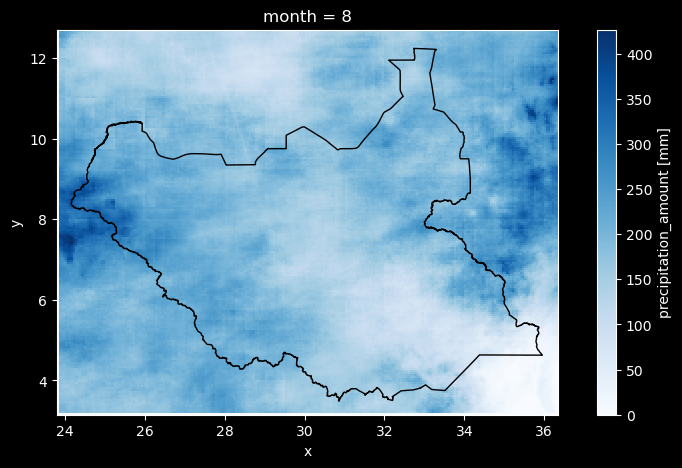

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
monthly_mean.isel(month=7).plot(ax=ax, cmap="Blues")
adm[adm.level == 0].plot(ax=ax, color="none", edgecolor="black", linewidth=1)

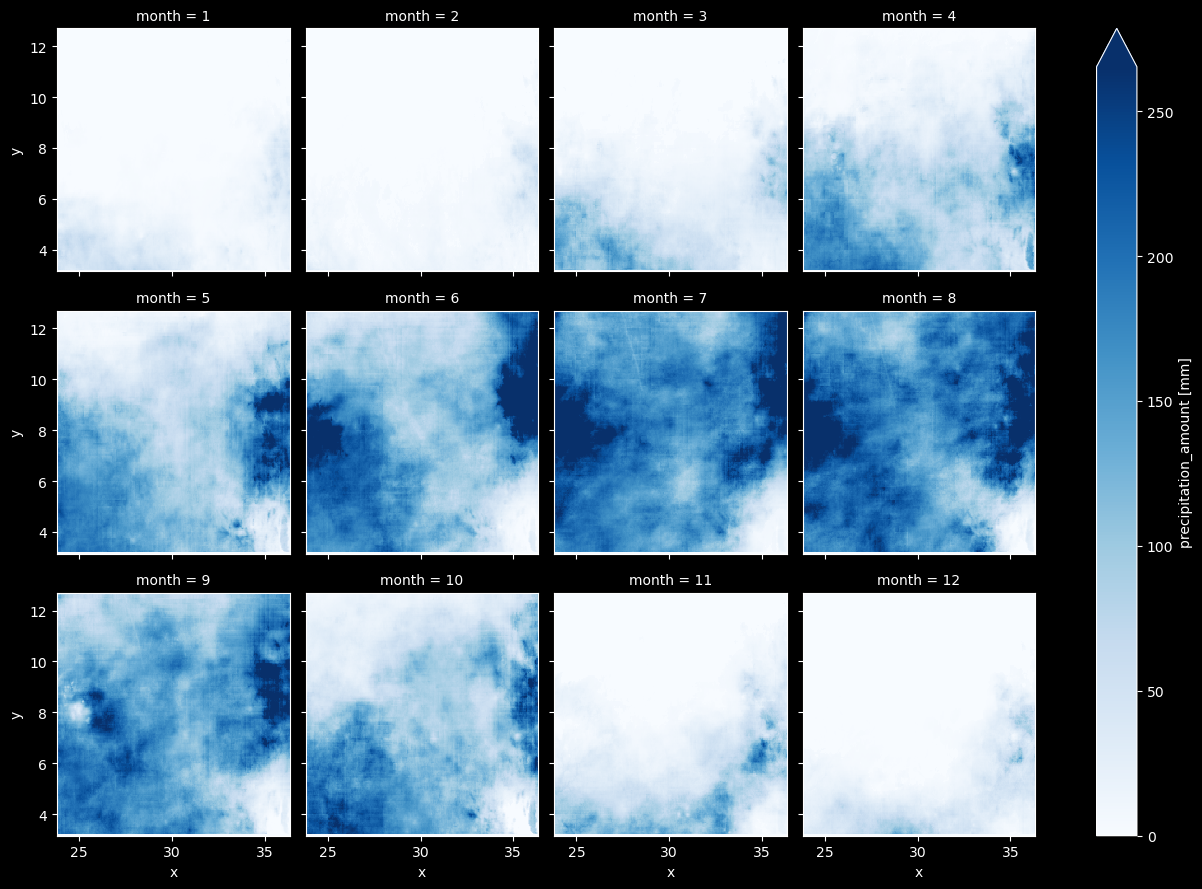

In [22]:
monthly_mean.plot(col="month", cmap="Blues", col_wrap=4, robust=True)

# Zonal statistics
## Predifined geometries
### Rasterize vector data
**Create the data mask by rasterizing the vector data**

First we need to rasterize the vector data to the same grid as the raster data. We will use the [`regionmask.mask_geopandas`](https://regionmask.readthedocs.io/en/stable/generated/regionmask.mask_geopandas.html#regionmask.mask_geopandas) function to rasterize the vector data to the same grid as the raster data.

In [40]:
level = 3
gdf = adm[adm.level == level].copy().reset_index()
gdf.head()

,index,level,adm0_en,adm0_pcode,adm1_en,adm1_pcode,adm2_en,adm2_pcode,adm3_en,adm3_pcode,geometry
0,0,3,South Sudan,SS,Abyei Region,SS00,Abyei Region,SS0001,Abyei Region,SS000101,"POLYGON ((28.03855 9.34390, 28.03606 9.34387, ..."
1,1,3,South Sudan,SS,Central Equatoria,SS01,Juba,SS0101,Bungu,SS010101,"POLYGON ((31.20592 4.81821, 31.21309 4.81718, ..."
2,2,3,South Sudan,SS,Central Equatoria,SS01,Juba,SS0101,Dolo,SS010102,"POLYGON ((31.26447 5.13648, 31.28455 5.12549, ..."
3,3,3,South Sudan,SS,Central Equatoria,SS01,Juba,SS0101,Ganji,SS010103,"POLYGON ((31.21002 4.62885, 31.21820 4.62271, ..."
4,4,3,South Sudan,SS,Central Equatoria,SS01,Juba,SS0101,Gondokoro,SS010104,"POLYGON ((31.70160 5.00761, 31.71640 4.99368, ..."


In [32]:
ds_monthly = xr.Dataset({"monthly_precipitation": monthly_mean})
ds_monthly

<xarray.Dataset> Size: 2MB
Dimensions:                (x: 251, y: 191, month: 12)
Coordinates:
  * x                      (x) float64 2kB 23.83 23.88 23.93 ... 36.28 36.33
  * y                      (y) float64 2kB 12.67 12.62 12.57 ... 3.225 3.175
  * month                  (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    monthly_precipitation  (month, y, x) float32 2MB dask.array<chunksize=(1, 24, 32), meta=np.ndarray>

In [36]:
# Create mask of multiple regions from shapefile
country_mask = regionmask.mask_geopandas(gdf, ds_monthly.x, ds_monthly.y, numbers="index")
country_mask

<xarray.DataArray 'mask' (y: 191, x: 251)> Size: 384kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 2kB 12.67 12.62 12.57 12.52 ... 3.325 3.275 3.225 3.175
  * x        (x) float64 2kB 23.83 23.88 23.93 23.98 ... 36.18 36.23 36.28 36.33
Attributes:
    standard_name:  region

**Let’s plot the new mask:**

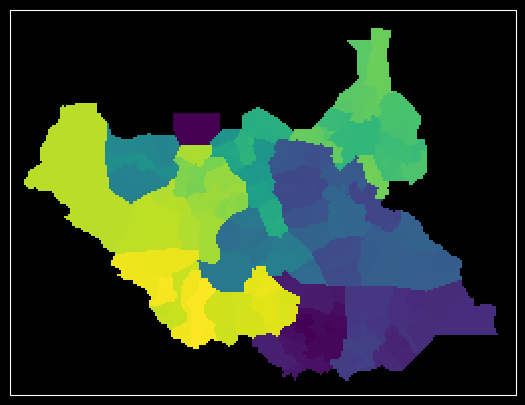

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})
country_mask.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)

ax.coastlines(color="w")

### Compute mean values for each indicator and time 
**Add mask as a new variable into the xarray.Dataset**

In [42]:
ds_masked = ds_monthly
ds_masked[f"adm_{str(level)}"] = country_mask
ds_masked

<xarray.Dataset> Size: 3MB
Dimensions:                (x: 251, y: 191, month: 12)
Coordinates:
  * x                      (x) float64 2kB 23.83 23.88 23.93 ... 36.28 36.33
  * y                      (y) float64 2kB 12.67 12.62 12.57 ... 3.225 3.175
  * month                  (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    monthly_precipitation  (month, y, x) float32 2MB dask.array<chunksize=(1, 24, 32), meta=np.ndarray>
    adm_3                  (y, x) float64 384kB nan nan nan nan ... nan nan nan

**Compute mean value over time**

In [43]:
# Define a function to compute the mean value for each group
def compute_mean(group):
    """
    Compute the mean total precipitation for each group.
    """
    bbox = group.total_bounds
    ds_tmp = ds_masked.sel(x=slice(bbox[0], bbox[2]), y=slice(bbox[3], bbox[1]))
    mean_value = (
        ds_tmp["monthly_precipitation"].where(ds_tmp["adm_3"] == group.name).mean(["x", "y"])
    )
    return mean_value.values


# Group the data by index and apply the function
mean_values = gdf.groupby("index").apply(compute_mean)

# Reset the index of mean_values
mean_values = mean_values.reset_index()
#
# Rename the columns of mean_values
mean_values.columns = ["index", "mean_total_precipitation"]

# Merge gdf and mean_values on 'index'
gdf = pd.merge(gdf, mean_values, on="index")

gdf.head()

2024-06-24 11:02:22,192 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-precipitation_amount-88d4bde4d452079dc9577cce59e1d8cf' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7f7264251f80>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7f714d6ef2c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _scale_offset_decoding at 0x

/tmp/ipykernel_216370/3410826139.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_values = gdf.groupby("index").apply(compute_mean)


,index,level,adm0_en,adm0_pcode,adm1_en,adm1_pcode,adm2_en,adm2_pcode,adm3_en,adm3_pcode,geometry,mean_total_precipitation
0,0,3,South Sudan,SS,Abyei Region,SS00,Abyei Region,SS0001,Abyei Region,SS000101,"POLYGON ((28.03855 9.34390, 28.03606 9.34387, ...","[0.041361738, 0.0, 0.09203354, 15.439056, 55.7..."
1,1,3,South Sudan,SS,Central Equatoria,SS01,Juba,SS0101,Bungu,SS010101,"POLYGON ((31.20592 4.81821, 31.21309 4.81718, ...","[6.8735423, 6.1141973, 51.838352, 77.646835, 1..."
2,2,3,South Sudan,SS,Central Equatoria,SS01,Juba,SS0101,Dolo,SS010102,"POLYGON ((31.26447 5.13648, 31.28455 5.12549, ...","[7.134349, 8.249879, 41.891304, 77.66992, 98.1..."
3,3,3,South Sudan,SS,Central Equatoria,SS01,Juba,SS0101,Ganji,SS010103,"POLYGON ((31.21002 4.62885, 31.21820 4.62271, ...","[8.439456, 7.5180173, 56.55159, 74.73835, 116...."
4,4,3,South Sudan,SS,Central Equatoria,SS01,Juba,SS0101,Gondokoro,SS010104,"POLYGON ((31.70160 5.00761, 31.71640 4.99368, ...","[3.3866472, 5.2020054, 42.26767, 73.78839, 99...."
